In [1]:
# Tutorial source: https://nbviewer.jupyter.org/github/krasserm/face-recognition/blob/master/face-recognition.ipynb?flush_cache=true

In [8]:
import helper, os

!pwd
!ls
!ls models/dlib

dst_dir = 'models/dlib'
dst_file = os.path.join(dst_dir, 'shape_predictor_68_face_landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    helper.download_landmarks(dst_file)

/Users/nmudivar/Projects/personal/face_rec
README.md                   main.py
__pycache__                 model.py
align.py                    models
app.log                     playground.ipynb
classifier.pkl              run_jupyter.sh
data                        start_docker.sh
env.sh                      start_docker_remote.sh
example_from_tutorial.ipynb util_scripts
facenet_training.log        utils.py
generated-embeddings        webcam.py
helper.py
shape_predictor_68_face_landmarks.dat


In [10]:
metadata = helper.load_metadata('data/photos/photos')

AttributeError: module 'helper' has no attribute 'load_metadata'

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline



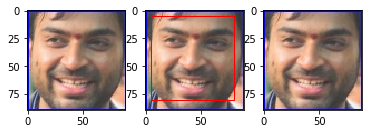

In [4]:
img_path = "images/Naren/face_11037.jpg"
helper.show_face_bound_and_alignment(img_path)
helper.show_image(img_path)

images/Naren/face_1784.jpg


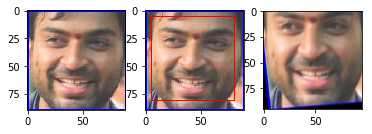

In [5]:
# Load an image
img_path = "images/Naren/face_11037.jpg"
jc_orig = helper.load_image(img_path)
print(metadata[80].image_path())
# Detect face and return bounding box
bb = helper.get_largest_bounding_box(jc_orig)

# jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
jc_aligned = helper.align_image(jc_orig)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [6]:
EMBEDDING_FIME_NAME = "embeddings.npy"

embedded = helper.get_embeddings(EMBEDDING_FIME_NAME)

In [10]:
print(len(embedded))
embedded[0].shape

325


(128,)

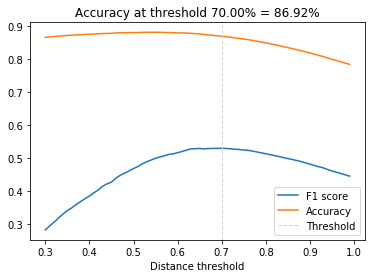

In [12]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(helper.distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {:.2%} = {:.2%}'.format(opt_tau, opt_acc));
plt.xlabel('Distance threshold')
plt.legend();

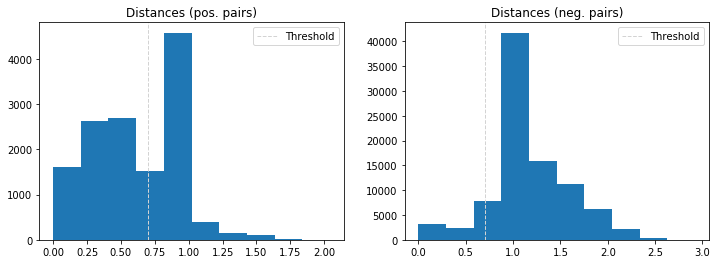

In [13]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

import numpy as np

EMBEDDING_FIME_NAME = "embeddings.npy"

metadata = helper.load_metadata('images')
embedded = helper.get_embeddings(EMBEDDING_FIME_NAME)

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0}, SVM accuracy = {1}'.format(acc_knn, acc_svc ))

KNN accuracy = 0.7668711656441718, SVM accuracy = 0.7668711656441718


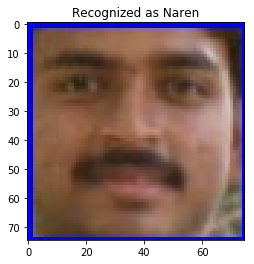

In [26]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 25

# image_path = "/home/naren/Projects/naren/face_rec/face_771796.jpg"

example_image = helper.load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title('Recognized as {}'.format(example_identity));

In [31]:
len(metadata)
embedded[test_idx][example_idx]

AttributeError: 'numpy.ndarray' object has no attribute 'image_path'

In [34]:
for i, m in enumerate(metadata):
    example_prediction = svc.predict([embedded[i]])
    identity = encoder.inverse_transform(example_prediction)[0]
    print( identity, m.image_path())

# plt.imshow(example_image)
# plt.title('Recognized as {}'.format(example_identity));

Susmita images/Acharyulu/face_958744.jpg
Susmita images/Acharyulu/face_908553.jpg
Susmita images/Acharyulu/face_968215.jpg
Acharyulu images/Acharyulu/face_971496.jpg
Acharyulu images/Acharyulu/face_944478.jpg
Acharyulu images/Acharyulu/face_924292.jpg
Acharyulu images/Acharyulu/face_998874.jpg
Acharyulu images/Acharyulu/face_886359.jpg
Acharyulu images/Acharyulu/face_10983.jpg
Acharyulu images/Acharyulu/face_894719.jpg
Acharyulu images/Acharyulu/face_958412.jpg
Susmita images/Acharyulu/face_9281.jpg
Acharyulu images/Acharyulu/face_955249.jpg
Susmita images/Acharyulu/face_10206.jpg
Acharyulu images/Acharyulu/face_946361.jpg
Susmita images/Acharyulu/face_942086.jpg
Jaya_Lakshmi images/Acharyulu/face_911997.jpg
Susmita images/Acharyulu/face_976792.jpg
Acharyulu images/Acharyulu/face_893023.jpg
Acharyulu images/Acharyulu/face_890808.jpg
Acharyulu images/Acharyulu/face_994895.jpg
Acharyulu images/Acharyulu/face_947064.jpg
Susmita images/Acharyulu/face_2390.jpg
Acharyulu images/Acharyulu/fac

In [21]:
print(test_idx, example_idx)
metadata[test_idx][example_idx].image_path()

[ True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False] 29


'images/Naren/face_11778.jpg'

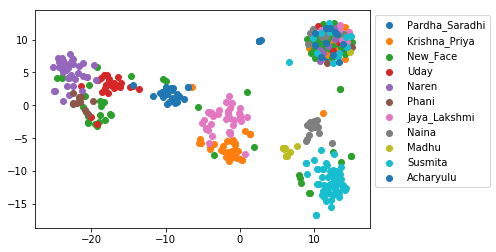

In [14]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

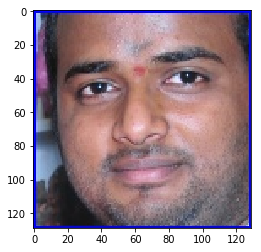

In [43]:
import cv2, helper, shutil

# image_path = "data/faces/face_322714.jpg"
image_path = "images/Phani/face_968250.jpg"

helper.show_image(image_path)

In [18]:
import os, helper, shutil

path = "data/faces"
invalid_faces_path = "data/faces_invalid"
predict_data = []

for i in os.listdir(path):
    img_path = os.path.join(path, i)
    img = helper.load_image(img_path)
    if img is not None:
        predict_data.append(helper.IdentityMetadata(path,"",i))
    else:
        shutil.move(img_path,  os.path.join(invalid_faces_path, i))
        print("Invalid image", img_path)

In [19]:
import numpy as np
len(predict_data)
predict_data = np.array(predict_data)

data/faces/face_330928.jpg


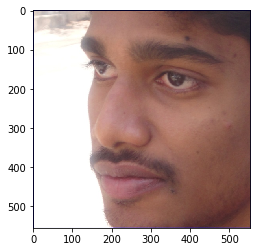

In [39]:
predict_data[0]
helper.show_image(predict_data[0].image_path())
print(predict_data[0].image_path())

In [23]:
predict_embeddings = helper.create_embeddings(predict_data[0:10])

data/faces/face_330928.jpg
Phani


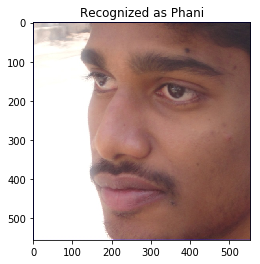

In [24]:
import warnings
import matplotlib.pyplot as plt

# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 0

# image_path = "/home/naren/Projects/naren/face_rec/face_771796.jpg"
print(predict_data[example_idx].image_path())
example_image = helper.load_image(predict_data[example_idx].image_path())
example_prediction = svc.predict([predict_embeddings[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]
print(example_identity)

plt.imshow(example_image)
plt.title('Recognized as {}'.format(example_identity));

In [44]:
def img_path_to_encoding(img_path):
    img = helper.load_image(img_path)
    if img is None:
        return None
    model = helper.get_model()
    img = helper.align_image(img)
    img = (img / 255.).astype(np.float32)
    encoding = model.predict(np.expand_dims(img, axis=0))[0]
    return encoding

rohit_encoding = img_path_to_encoding("data/faces/face_330928.jpg")
phani_encoding = img_path_to_encoding("images/Phani/face_968250.jpg")

In [46]:
dist = np.linalg.norm(rohit_encoding - phani_encoding)
print('distance for %s is %s' %("name", dist))

distance for name is 0.589943


In [3]:
import os, helper
import numpy as np
phani_encoding = helper.img_path_to_encoding("images/Phani/face_968250.jpg")

for i in os.listdir("images/Phani"):
    encoding = helper.img_path_to_encoding(os.path.join("images/Phani/", i))
    if encoding is None:
        continue
    dist = np.linalg.norm(phani_encoding - encoding)
    print('distance for %s is %s' %(i, dist))

distance for face_5304.jpg is 0.559029
distance for face_3998.jpg is 0.488431
distance for face_596490.jpg is 0.467525
images/Phani/face_872597.jpg unsupported operand type(s) for /: 'NoneType' and 'float'
distance for face_938607.jpg is 0.444164
distance for face_852527.jpg is 0.404494
distance for face_967385.jpg is 0.610651
distance for face_838790.jpg is 0.434211
distance for face_911980.jpg is 0.301904
distance for face_994504.jpg is 0.352016
images/Phani/face_992562.jpg unsupported operand type(s) for /: 'NoneType' and 'float'
distance for face_966498.jpg is 0.611022
distance for face_922303.jpg is 0.397
distance for face_968250.jpg is 0.0
